<a href="https://colab.research.google.com/github/Yarida2543/weatherwise.Yarida/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [10]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai


In [91]:
import os

# Configure your provider
os.environ['HANDS_ON_AI_SERVER'] = 'https://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'llama3.2'
os.environ['HANDS_ON_AI_API_KEY'] = '88b4bd057b654b60af65bb248c944244.TyY60d2n08CBPetkeY71GwEv'

from hands_on_ai.chat import get_response
print(get_response("As a current weather in Australia, Perth today is 30 degrees celcius, with uv index of, and partial clouds, Can I swim in the pool?"))

Considering the current weather in Perth:

- Temperature: 30°C (which may feel hot for some people)
- UV Index: Unfortunately, without a specific value for the UV index, it's difficult to provide guidance. However, if it's moderate or high, swimming outdoors might not be the best idea during peak sun hours.
- Sky Conditions: Partly cloudy

Given these conditions, I would say that it's still possible to swim in a pool, but with some caution:

1. Take extra precautions: Consider seeking shade when spending time outdoors, and wear protective clothing like a hat, sunglasses, and sunscreen to protect yourself from the sun's rays, especially during peak UV hours (usually between 10am and 4pm).
2. Be mindful of heat exhaustion: Swimming in the pool can be exhilarating on hot days, but don't underestimate the risks. Listen to your body and take regular breaks in shaded areas if you need to.
3. Consider alternative swimming times: If possible, plan your outdoor swim during cooler parts of the d

## 📦 Setup and Configuration
Import required packages and setup environment.

In [21]:
# Core libraries
import os
import re
from typing import Dict, Any, List, Optional, Tuple, Union
import requests
import matplotlib.pyplot as plt

os.environ["OPENWEATHER_API_KEY"] = "3a10e176bbe73766db6e4d09a4bd96d0"  # Demo key, get your own at https://openweathermap.org/api


# pyinputplus is preferred for menus, but guard if missing in some environments
try:
	import pyinputplus as pyip
except Exception:
	pyip = None  # UI cell will handle None gracefully

# Fetch weather via the teaching helper library
try:
	import fetch_my_weather as fmw
except Exception as e:
	fmw = None
	print("Warning: fetch_my_weather not installed. You can install it in Colab by running the optional pip cell above.")

# Global state used by UI/demo (kept minimal)
_LAST_LOCATION: Optional[str] = None
_LAST_FORECAST_DAYS: int = 5
_LAST_WEATHER: Optional[Dict[str, Any]] = None

# Helper for safe matplotlib usage in notebooks
plt.rcParams.update({
	"figure.figsize": (8, 4),
	"axes.grid": True,
})

## 🌤️ Weather Data Functions

In [52]:
# Define get_weather_data() function here
from typing import TypedDict

class ParsedWeather(TypedDict, total=False):
        location: str
        forecast_days: int
        error: Optional[str]
        current: Dict[str, Any]
        daily: List[Dict[str, Any]]


def _normalize_fmw_json(model_or_dict: Any) -> Dict[str, Any]:
        """
        Convert fetch_my_weather WeatherResponse (Pydantic) or raw dict to a plain dict.
        This keeps only the keys we care about for the assignment to simplify downstream code.
        """
        # If it's a pydantic model, use model_dump if available
        if hasattr(model_or_dict, "model_dump"):
                data = model_or_dict.model_dump()  # type: ignore[attr-defined]
        else:
                data = dict(model_or_dict)
        return data

def openWeather_getWeather(city: str, units: str = "metric"):
        api_key = os.getenv("OPENWEATHER_API_KEY")
        if not api_key:
                return None
        try:
                CITY = city
                UNITS = units  # metric for °C or "imperial" for °F
                # Step 1: Call the 5-day forecast API
                url = f"https://api.openweathermap.org/data/2.5/forecast?q={CITY}&appid={api_key}&units={UNITS}"
                response = requests.get(url)
                response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
                data = response.json()
                return data
        except requests.exceptions.RequestException as e:
                print(f"Error fetching weather data from OpenWeatherMap: {e}")
                return {"error": f"Failed to fetch weather data: {e}"}
        except Exception as e:
                print(f"An unexpected error occurred: {e}")
                return {"error": f"An unexpected error occurred: {e}"}





def get_weather_data(city: str, forecast_days: int = 5):
        """
        Retrieve weather data for a specified location.

        Args:
                location (str): City or location name
                forecast_days (int): Number of days to forecast (1-5)

        Returns:
                dict: Weather data including current conditions and forecast
        """
        result: ParsedWeather = {
              "location": city,
              "forecast_days": max(1, min(int(forecast_days or 5), 5)),
        }

        if not city or not isinstance(city, str):
              result["error"] = "Invalid location provided."
              return result


        response_data = openWeather_getWeather(city=city, units="metric")

        if response_data and "list" in response_data:
            # Process OpenWeatherMap forecast data to match expected 'daily' structure
            daily_forecasts: List[Dict[str, Any]] = []
            # OpenWeatherMap provides data in 3-hour intervals for 5 days.
            # We need to aggregate this into daily data.
            # A simple approach is to take data points around midday for each day.
            # A more robust approach would be to calculate daily averages/max/min.
            # For now, let's extract relevant data points for the requested number of days.

            # Group data by day
            daily_data: Dict[str, List[Dict[str, Any]]] = {}
            for item in response_data["list"]:
                date_str = item["dt_txt"].split(" ")[0]
                if date_str not in daily_data:
                    daily_data[date_str] = []
                daily_data[date_str].append(item)

            # Extract daily summary for the requested number of days
            from datetime import datetime, timedelta
            today = datetime.now().date()
            dates_to_include = [(today + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(result["forecast_days"])]

            for date_str in dates_to_include:
                if date_str in daily_data:
                    day_items = daily_data[date_str]
                    # Simple aggregation: take the item closest to midday for a snapshot,
                    # or calculate averages/max/min. Let's calculate max/min temp and average precip.
                    if day_items:
                        max_temp = max(item["main"]["temp_max"] for item in day_items)
                        min_temp = min(item["main"]["temp_min"] for item in day_items)
                        total_precip_mm = sum(item.get("rain", {}).get("3h", 0) for item in day_items) # OpenWeatherMap gives rain in 3h intervals
                        # Find a representative weather description (e.g., from midday)
                        representative_item = None
                        min_diff = float('inf')
                        for item in day_items:
                            time_str = item["dt_txt"].split(" ")[1]
                            hour = int(time_str.split(":")[0])
                            diff = abs(hour - 12) # Closest to midday (12:00)
                            if diff < min_diff:
                                min_diff = diff
                                representative_item = item

                        weather_desc = (representative_item.get("weather", [{}])[0].get("description", "")) if representative_item else ""


                        daily_forecasts.append({
                            "date": date_str,
                            "maxtempC": str(round(max_temp, 2)), # Store as string to match old structure
                            "mintempC": str(round(min_temp, 2)), # Store as string to match old structure
                            "totalPrecipMM": str(round(total_precip_mm, 2)), # Store as string
                            "weatherDesc": [{"value": weather_desc}] # Store as list of dicts to match old structure
                            # Add other fields if needed by visualization or summary functions
                        })

            result["daily"] = daily_forecasts
            # For current data, OpenWeatherMap has a separate endpoint, but for simplicity,
            # we can try to extract the first available forecast entry if it's for today.
            if response_data["list"]:
                 first_item = response_data["list"][0]
                 if first_item["dt_txt"].split(" ")[0] == today.strftime("%Y-%m-%d"):
                     result["current"] = {
                         "temp_C": first_item["main"]["temp"],
                         "FeelsLikeC": first_item["main"]["feels_like"],
                         "weatherDesc": first_item["weather"],
                         "precipMM": first_item.get("rain", {}).get("3h", 0), # Precipitation in last 3 hours
                         "windspeedKmph": first_item["wind"]["speed"] * 3.6, # Convert m/s to km/h
                         "winddir16Point": None # OpenWeatherMap provides degrees, not 16-point
                     }


        elif response_data and response_data.get("error"):
             result["error"] = response_data["error"]
        else:
             result["error"] = "Failed to retrieve weather forecast data."


        return result

## 📊 Visualisation Functions

In [105]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
from datetime import datetime
import matplotlib.pyplot as plt
import time # Import time for potential pause

def _extract_day_labels(daily: List[Dict[str, Any]]) -> List[str]:
        labels: List[str] = []
        for d in daily:
                date_str = d.get("date") or d.get("astronomy", [{}])[0].get("sunrise")
                try:
                        labels.append(datetime.strptime(date_str, "%Y-%m-%d").strftime("%a %d"))
                except Exception:
                        labels.append(str(date_str))
        return labels


def create_temperature_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
        """
        Create visualisation of temperature data.

        Args:
                weather_data (dict): The processed weather data
                output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

        Returns:
                If output_type is 'figure', returns the matplotlib figure object
                Otherwise, displays the visualisation in the notebook
        """

        # get daily forecast data
        daily = weather_data.get("daily", [])
        if not daily:
                print("No daily forecast data available to plot temperatures.")
                return None

        # create x-axis max/min temperature plots label
        max_t = [float(d.get("maxtempC") or 0) for d in daily]
        min_t = [float(d.get("mintempC") or 0) for d in daily]
        labels = _extract_day_labels(daily)

        fig, ax = plt.subplots()
        ax.plot(labels, max_t, marker='o', label='Max Temp (°C)')
        ax.plot(labels, min_t, marker='o', label='Min Temp (°C)')
        ax.set_title("Daily Temperature Forecast")
        ax.set_xlabel("Day")
        ax.set_ylabel("Temperature (°C)")
        ax.legend()
        plt.xticks(rotation=0)
        plt.tight_layout()

        if output_type == 'figure':
                return fig
        else:
                # Use block=False to try and prevent blocking
                plt.show(block=False)
                # Add a small pause to allow the plot window to appear before the next prompt
                plt.pause(0.1)
                # You might need to close the plot window manually to fully return control
                return None

In [104]:
# Define create_precipitation_visualisation() here
from datetime import datetime
import matplotlib.pyplot as plt
import time # Import time for potential pause

def create_precipitation_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
        """
        Create visualisation of precipitation data.

        Args:
                weather_data (dict): The processed weather data
                output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

        Returns:
                If output_type is 'figure', returns the matplotlib figure object
                Otherwise, displays the visualisation in the notebook
        """
        daily = weather_data.get("daily", [])
        if not daily:
                print("No daily forecast data available to plot precipitation.")
                return None

        # Some wttr.in data uses hourly precipitation; daily often contains total precipitation in mm
        # We'll use total precipitation in mm if available; otherwise, estimate from hourly
        totals: List[float] = []
        labels = _extract_day_labels(daily)

        for d in daily:
                mm = d.get("totalPrecipMM")
                if mm is None and d.get("hourly"):
                        try:
                                mm = sum(float(h.get("precipMM") or 0.0) for h in d["hourly"])  # type: ignore[index]
                        except Exception:
                                mm = 0.0
                try:
                        totals.append(float(mm))
                except Exception:
                        totals.append(0.0)

        fig, ax = plt.subplots()
        ax.bar(labels, totals, color="cyan")
        ax.set_title("Forecast Precipitation")
        ax.set_xlabel("Day")
        ax.set_ylabel("Precipitation (mm)")
        plt.tight_layout()

        if output_type == 'figure':
                return fig
        else:
                # Use block=False to try and prevent blocking
                plt.show(block=False)
                # Add a small pause to allow the plot window to appear before the next prompt
                plt.pause(0.1)
                # You might need to close the plot window manually to fully return control
                return None

## 🤖 Natural Language Processing

In [77]:
def parse_weather_question(question: str) -> Dict[str, Any]:
        """
        Parse a natural language weather question.

        Args:
                question (str): User's weather-related question

        Returns:
                dict: Extracted information including location, time period, and weather attribute
        """
        if not question or not isinstance(question, str):
                return {"error": "Invalid question provided."}

        # Simple parsing: look for keywords
        q = question.strip().lower()

        # Example parsing for temperature, rain, or wind
        attribute = None
        if "temperature" in q or "hot" in q or "cold" in q:
            attribute = "temperature"
        elif "rain" in q or "precipitation" in q or "wet" in q:
            attribute = "precipitation"
        elif "wind" in q or "breezy" in q:
            attribute = "wind"
        # Add more attributes as needed (e.g., humidity, UV index if available)

        # Example parsing for time (today, tomorrow, a specific date - basic)
        time_spec: Union[int, str, None] = None
        if "today" in q:
            time_spec = 0 # 0 for today
        elif "tomorrow" in q:
            time_spec = 1 # 1 for tomorrow
        # You could add more complex date parsing here if needed

        # Location parsing: look for 'in X', 'for X', 'at X' (basic)
        location = None
        # This is a very simple regex, you might need a more robust one
        location_match = re.search(r"in\s([\w\s]+)|for\s([\w\s]+)|at\s([\w\s]+)", q)
        if location_match:
            location = next((g for g in location_match.groups() if g), None)
            if location:
                location = location.strip().title()

        return {
                "raw": question,
                "location": location,
                "attribute": attribute,
                "time": time_spec,
        }

## 🧭 User Interface

In [100]:
# Define menu functions using pyinputplus or ipywidgets here
import json
from datetime import datetime, timedelta

def get_temps(weather_data: Dict[str, Any]) -> Dict[str, List[float]]:
    """Extract daily temperatures from processed weather data."""
    daily_temps: Dict[str, List[float]] = {}
    daily = weather_data.get("daily", [])
    for day_data in daily:
        date_str = day_data.get("date")
        if date_str:
            # Use min and max temp from daily summary
            min_temp = day_data.get("mintempC")
            max_temp = day_data.get("maxtempC")
            if min_temp is not None:
                 if date_str not in daily_temps:
                     daily_temps[date_str] = []
                 daily_temps[date_str].append(float(min_temp))
            if max_temp is not None:
                 if date_str not in daily_temps:
                     if date_str not in daily_temps:
                         daily_temps[date_str] = []
                     daily_temps[date_str].append(float(max_temp))
            # If needed, you could also average hourly data if available in the processed structure
    return daily_temps


def get_humidity(weather_data: Dict[str, Any]) -> Dict[str, List[float]]:
    """Extract daily humidity (placeholder - OpenWeatherMap forecast doesn't provide daily humidity directly)."""
    # OpenWeatherMap 5-day forecast provides humidity in 3-hour intervals.
    # To get daily humidity, you'd typically average or take a specific time's reading.
    # For simplicity here, we'll return an empty dict or implement aggregation if needed later.
    # If your processed weather_data included aggregated daily humidity, you would extract it here.
    print("Note: Daily humidity data is not directly available in this OpenWeatherMap forecast endpoint.")
    return {}

def get_wind(weather_data: Dict[str, Any]) -> Dict[str, List[float]]:
    """Extract daily wind speeds (placeholder - OpenWeatherMap forecast doesn't provide daily wind directly)."""
    # Similar to humidity, wind speed is in 3-hour intervals.
    # You would need to aggregate this data for a daily value.
    print("Note: Daily wind speed data is not directly available in this OpenWeatherMap forecast endpoint.")
    return {}

def get_uv(weather_data: Dict[str, Any]) -> Dict[str, List[float]]:
    """Extract daily UV index (placeholder - OpenWeatherMap forecast doesn't provide UV index)."""
    # OpenWeatherMap's 5-day forecast does not include UV index.
    # A separate API call or a different weather data source would be needed for this.
    print("Note: UV index data is not available in this OpenWeatherMap forecast endpoint.")
    return {}


def run_console_menu():
        """Simple console menu using pyinputplus if available, else fallback to input()."""
        global _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER

        def ask(prompt: str, choices: Optional[List[str]] = None) -> str:
                if pyip and choices:
                        return pyip.inputMenu(choices, prompt=prompt + "\n", numbered=True)
                elif pyip:
                        return pyip.inputStr(prompt)
                else:
                        # basic fallback
                        return input(prompt + (f" ({'/'.join(choices)})" if choices else "") + ": ")

        # Ask for location once at the beginning
        loc = ask("Enter location (e.g., Perth)")
        _LAST_LOCATION = loc # Store the location


        while True:
                choices = [
                        "Get weather today",
                        "Show temperature chart",
                        "Show Precipitation chart", # Changed from "Show weather summary"
                        "Ask any question",
                        "Quit",
                ]
                # Use _LAST_LOCATION in the prompt
                choice = ask(f"Choose an option for {_LAST_LOCATION}", choices)


                if choice == choices[0]:
                        # This option now fetches data specifically for today (1 day forecast)
                        days = 1
                        data = get_weather_data(_LAST_LOCATION, forecast_days=days)
                        _LAST_FORECAST_DAYS, _LAST_WEATHER = days, data

                        if data and not data.get("error"):
                            today_date_str = datetime.now().strftime("%Y-%m-%d")

                            # For "Get weather today", use 'current' data if available
                            current_weather = data.get("current")
                            if current_weather:
                                print(f"Current weather in {_LAST_LOCATION}:")
                                print(f"  Temperature: {round(current_weather.get('temp_C', 0), 2)} °C")
                                print(f"  Feels Like: {round(current_weather.get('FeelsLikeC', 0), 2)} °C")
                                weather_desc = current_weather.get("weatherDesc", [{}])[0].get("description", "N/A")
                                print(f"  Conditions: {weather_desc}")
                                print(f"  Precipitation (last 3h): {round(current_weather.get('precipMM', 0), 2)} mm")
                                print(f"  Wind Speed: {round(current_weather.get('windspeedKmph', 0), 2)} km/h")
                                # Humidity and UV are not in the 'current' data from this endpoint
                            else:
                                # Fallback to daily forecast for today if current is not available
                                daily_forecasts = data.get("daily", [])
                                today_forecast = next((d for d in daily_forecasts if d.get("date") == today_date_str), None)
                                if today_forecast:
                                     print(f"Weather forecast for {_LAST_LOCATION} today ({today_date_str}):")
                                     print(f"  Max Temp: {today_forecast.get('maxtempC', 'N/A')} °C")
                                     print(f"  Min Temp: {today_forecast.get('mintempC', 'N/A')} °C")
                                     weather_desc = today_forecast.get("weatherDesc", [{}])[0].get("value", "N/A")
                                     print(f"  Conditions: {weather_desc}")
                                     print(f"  Total Precipitation: {today_forecast.get('totalPrecipMM', 'N/A')} mm")
                                     # Note: Wind, Humidity, UV not directly available in daily summary from this endpoint
                                else:
                                    print(f"No weather data available for {_LAST_LOCATION} today.")
                        elif data and data.get("error"):
                             print(f"Error fetching weather: {data['error']}")
                        else:
                             print("Failed to fetch weather data.")


                elif choice == choices[1] or choice == choices[2]: # Handle both chart options here
                        days_str = ask("Forecast days (1-5)")
                        try:
                                days = max(1, min(int(days_str), 5))
                        except Exception:
                                days = 5

                        # Fetch weather data for the specified number of days for the chart
                        data = get_weather_data(_LAST_LOCATION, forecast_days=days)
                        _LAST_FORECAST_DAYS, _LAST_WEATHER = days, data # Update global state

                        if data and not data.get("error"):
                            if choice == choices[1]:
                                create_temperature_visualisation(_LAST_WEATHER, output_type='display')
                            elif choice == choices[2]:
                                create_precipitation_visualisation(_LAST_WEATHER)
                        elif data and data.get("error"):
                             print(f"Error fetching weather for chart: {data['error']}")
                        else:
                             print("Failed to fetch weather data for chart.")


                elif choice == choices[3]:
                        q = ask("Ask a weather question (e.g., 'Will it rain tomorrow in Sydney?')")
                        parsed = parse_weather_question(q)
                        # TODO : Edit function content
                        resp = generate_weather_response(parsed, _LAST_WEATHER)
                        print(resp)

                elif choice == choices[4]:
                        print("Goodbye have a great day!")
                        break

## 🧩 Main Application Logic

In [93]:
# Tie everything together here
from hands_on_ai.chat import get_response


def generate_weather_response(parsed_question: Dict[str, Any], weather_data: Dict[str, Any]) -> str:
        """
        Generate a natural language response to a weather question using AI.

        Args:
                parsed_question (dict): Parsed question data
                weather_data (dict): Weather data

        Returns:
                str: Natural language response generated by AI
        """
        if parsed_question.get("error"):
                return parsed_question["error"]
        if weather_data.get("error"):
                return weather_data["error"]

        location = weather_data.get("location") or parsed_question.get("location") or "the selected location"
        current = weather_data.get("current", {})
        daily = weather_data.get("daily", [])

        # Construct a prompt for the AI model
        # Provide the AI with the weather data as context
        weather_context = f"Weather data for {location}:\n"
        if current:
            weather_context += f"Current conditions: Temperature: {current.get('temp_C')}°C, Feels like: {current.get('FeelsLikeC')}°C, Conditions: {current.get('weatherDesc', [{}])[0].get('description')}, Precipitation (last 3h): {current.get('precipMM')}mm, Wind Speed: {current.get('windspeedKmph')} km/h.\n"
        if daily:
            weather_context += "Daily forecast:\n"
            for day in daily:
                weather_context += f"  {day.get('date')}: Max Temp: {day.get('maxtempC')}°C, Min Temp: {day.get('mintempC')}°C, Conditions: {day.get('weatherDesc', [{}])[0].get('value')}, Precipitation: {day.get('totalPrecipMM')}mm.\n"

        user_question = parsed_question.get("raw", "Tell me about the weather.")

        # Combine context and question for the AI
        ai_prompt = f"{weather_context}\nBased on this weather data, please answer the following question: {user_question}"

        # Get response from the AI model
        try:
            ai_response = get_response(ai_prompt)
            return ai_response
        except Exception as e:
            return f"Error generating AI response: {e}"

## 🧪 Testing and Examples

Enter location (e.g., Perth)Perth
Choose an option for Perth
1. Get weather today
2. Show temperature chart
3. Show Precipitation chart
4. Ask any question
5. Quit
1
Current weather in Perth:
  Temperature: 23.08 °C
  Feels Like: 22.98 °C
  Conditions: scattered clouds
  Precipitation (last 3h): 0 mm
  Wind Speed: 12.96 km/h
Choose an option for Perth
1. Get weather today
2. Show temperature chart
3. Show Precipitation chart
4. Ask any question
5. Quit
2
Forecast days (1-5)3


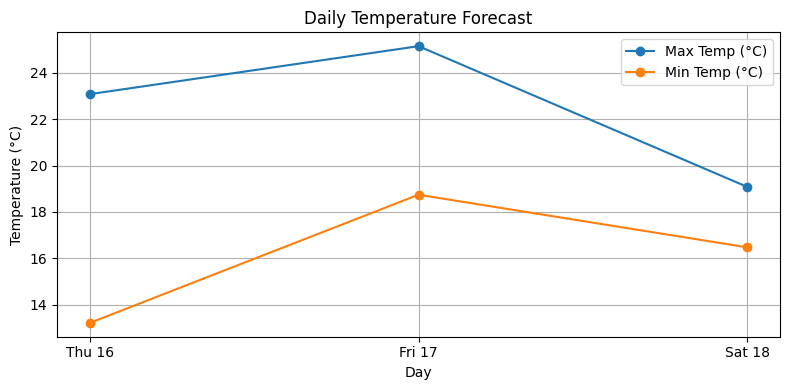

Choose an option for Perth
1. Get weather today
2. Show temperature chart
3. Show Precipitation chart
4. Ask any question
5. Quit
3
Forecast days (1-5)5


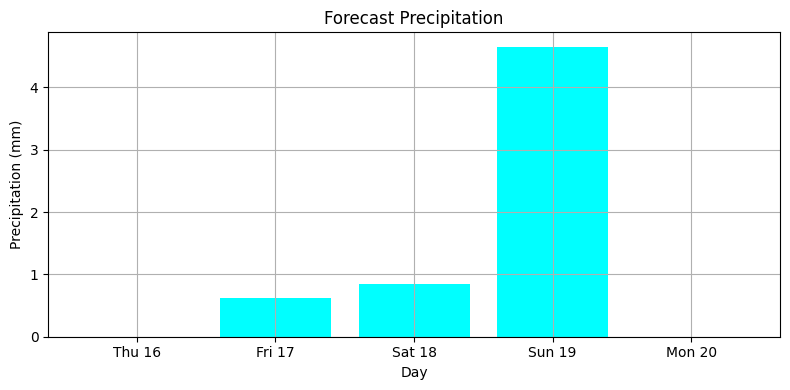

Choose an option for Perth
1. Get weather today
2. Show temperature chart
3. Show Precipitation chart
4. Ask any question
5. Quit
4
Ask a weather question (e.g., 'Will it rain tomorrow in Sydney?')Should i have  to bring umbralla
According to the daily forecast for October 18th (which is today!), there's a chance of precipitation with an expected amount of 0.84mm due to overcast clouds.

Considering it's not extremely heavy rain and you mentioned 'scattered clouds' currently, but specifically 'overcast clouds' with precipitation in your forecast for the current day, I would recommend bringing an umbrella. Overcast skies often imply precipitation, so it's better to be prepared for that.

However, the amount of precipitation is relatively low (0.84mm), and you should also consider the current weather conditions as 'scattered clouds'. Nevertheless, if there were at least a higher chance of continuous or moderate rain I would rather say yes do bring an umbrella however for today the answer

In [106]:
# Include sample input/output for each function
run_console_menu()

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.